In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from matplotlib.pyplot import imshow
%matplotlib inline

## Import data

In [4]:
TRAIN_FILE ='train-images.idx3-ubyte'
TRAIN_LABEL ='train-labels.idx1-ubyte'
TEST_FILE ='t10k-images.idx3-ubyte'
TEST_LABEL ='t10k-labels.idx1-ubyte'

In [5]:
with open(TRAIN_FILE, 'rb') as ftemp:
    datatemp = np.fromfile(ftemp, dtype = np.ubyte)
    dataRTrain = datatemp[16::].reshape(60000,784)
    print('Size of the training set:',dataRTrain.shape)

with open(TRAIN_LABEL, 'rb') as ftemp:
    datatemp = np.fromfile(ftemp, dtype = np.ubyte)
    labelRTrain = datatemp[8::]
    print('Size of the training labels:',labelRTrain.shape)
    
with open(TEST_FILE, 'rb') as ftemp:
    datatemp = np.fromfile(ftemp, dtype = np.ubyte)
    dataRTest = datatemp[16::].reshape(10000,784)
    print('Size of the test set:',dataRTest.shape)
    
with open(TEST_LABEL, 'rb') as ftemp:
    datatemp = np.fromfile(ftemp, dtype = np.ubyte)
    labelRTest = datatemp[8::]
    print('Size of the test label:',labelRTest.shape)

Size of the training set: (60000, 784)
Size of the training labels: (60000,)
Size of the test set: (10000, 784)
Size of the test label: (10000,)


## Convert to pandas data frame

In [6]:
dfTrain = pd.DataFrame(dataRTrain)
dfTrain['label'] = labelRTrain
dfTrain.set_index(['label'], inplace = True)
dflabelGrp = dfTrain.groupby('label')

# Part 1
## Code to find and render mean and Standard Deviation digits

Mean Digits		 Standard Deviation digits


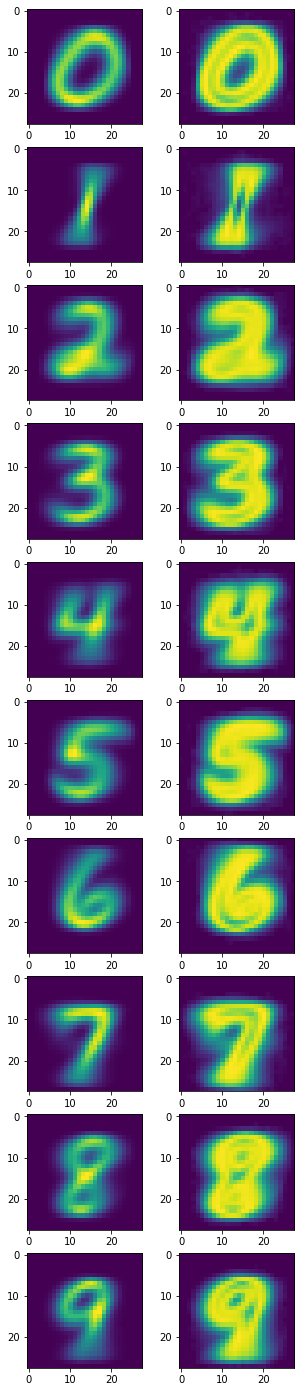

In [7]:
fig, axes = plt.subplots(nrows = 10, ncols = 2, figsize=(5,25))
print("Mean Digits\t\t Standard Deviation digits")
label_means = np.array([])
for i in range(10):
    temp = dflabelGrp.mean().loc[i].to_numpy().reshape(28,28)
    label_means = np.append(label_means, temp)
    temp = temp.reshape(28,28)
    axes[i][0].imshow(temp)
    temp = dflabelGrp.std().loc[i].to_numpy().reshape(28,28)
    axes[i][1].imshow(temp)

# Part 2
## Finding the prior probablity

In [53]:
labelProbs = (np.bincount(np.sort(labelRTrain))/60000)
label_means = label_means.reshape(10,784)

In [54]:
cov = dflabelGrp.cov().to_numpy()
cov = cov.reshape(10,784,784)
np.random.seed(1)

### Adding noise to the covarience matrix

In [55]:
for i in range(10):
    cov[i] = cov[i] + np.eye(784)*0.1*np.random.rand(784,784)

In [56]:
# cv = torch.from_numpy(cov).to(device)
# sign,cv_det = torch.slogdet(cv)
# print(cv_det)

In [57]:
prediction = []
loss = 0;

## Using pytorch tensors to run matrix multiplications on GPU

In [58]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Defining formula terms
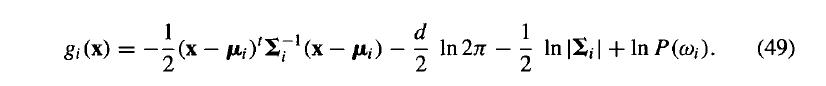

In [59]:
lm = torch.from_numpy(label_means).to(device)
cv = torch.from_numpy(cov).to(device)
sign,cv_det = torch.slogdet(cv)
cv = torch.inverse(cv)
d = len(dataRTest)
PI = torch.tensor(np.pi).to(device)
b = d/2*torch.log(2*PI)
prior_likely = torch.log(torch.from_numpy(labelProbs).to(device))

In [60]:
def predictgpu(x):
    x = torch.from_numpy(x).to(device)
    gx = []
    for i in range(10):
        gx.append(-0.5*torch.t((x-lm[i]).view(784,1)).mm(cv[i]).mm((x-lm[i]).view(784,1)) - b - 0.5*cv_det[i] + prior_likely[i])
    pr = torch.tensor(gx).to(device)
    return torch.argmax(pr)

In [61]:
prediction = []
loss = 0;
for x in range(10000):
    prediction.append(predictgpu(dataRTest[x]))
#     print(prediction[-1],end=' ')
    if prediction[-1]!=labelRTest[x]:
        loss += 1

In [62]:
print("loss% =",loss/100,"Accuracy% =", 100-loss/100)

loss% = 20.73 Accuracy% = 79.27


## Not as good as other methods on lecun's website
* Fisher’s approach  to  discriminant  problem  is  parametric  and  relies  on assumptions such as multivariate normality for optimality and, therefore, may be less effective on more realistic classes of problems.
* Parametric assumptions (multivariate normality, equalityof covariance matrices) and linearity assumption are particularly restrictive and reduce the effectiveness of discriminant analysis when the group data structure is complex
* Discriminant analysis is sensitive to outliers.